In [1]:
import paddle
import paddle.nn.functional as F
from paddle.vision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

C:\Users\MoonN\Environment\Languages\Anaconda3\envs\paddle\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
transform = ToTensor()
cifar10_train = paddle.vision.datasets.Cifar10(mode='train',
                                               transform=transform)
cifar10_test = paddle.vision.datasets.Cifar10(mode='test',
                                              transform=transform)

In [3]:
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [4]:
epoch_num = 10
batch_size = 32
learning_rate = 0.001

In [5]:
val_acc_history = []
val_loss_history = []

def train(model):
    print('start training ... ')
    # turn into training mode
    model.train()

    opt = paddle.optimizer.Adam(learning_rate=learning_rate,
                                parameters=model.parameters())

    train_loader = paddle.io.DataLoader(cifar10_train,
                                        shuffle=True,
                                        batch_size=batch_size, places=paddle.CUDAPlace(0))

    valid_loader = paddle.io.DataLoader(cifar10_test, batch_size=batch_size, places=paddle.CUDAPlace(0))
    
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)

            if batch_id % 1000 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[validation] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        val_acc_history.append(avg_acc)
        val_loss_history.append(avg_loss)
        model.train()

model = MyNet(num_classes=10)
train(model)

start training ... 
epoch: 0, batch_id: 0, loss is: [2.623928]
epoch: 0, batch_id: 1000, loss is: [1.2787316]
[validation] accuracy/loss: 0.5622004866600037/1.2255898714065552
epoch: 1, batch_id: 0, loss is: [1.1795142]
epoch: 1, batch_id: 1000, loss is: [1.1328046]
[validation] accuracy/loss: 0.6170127987861633/1.090306043624878
epoch: 2, batch_id: 0, loss is: [0.9470457]
epoch: 2, batch_id: 1000, loss is: [0.7177377]
[validation] accuracy/loss: 0.6424720287322998/1.0408756732940674
epoch: 3, batch_id: 0, loss is: [0.7600796]
epoch: 3, batch_id: 1000, loss is: [0.94585925]
[validation] accuracy/loss: 0.6882987022399902/0.8978747129440308
epoch: 4, batch_id: 0, loss is: [0.79086345]
epoch: 4, batch_id: 1000, loss is: [0.69750154]
[validation] accuracy/loss: 0.6728234887123108/0.9366930723190308
epoch: 5, batch_id: 0, loss is: [0.8024772]
epoch: 5, batch_id: 1000, loss is: [0.45184907]
[validation] accuracy/loss: 0.6917931437492371/0.9115167856216431
epoch: 6, batch_id: 0, loss is: [0.7

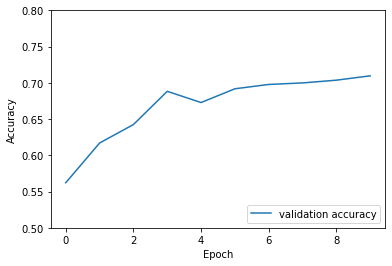

In [14]:
plt.plot(val_acc_history, label = 'validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.8])
plt.legend(loc='lower right')